# Mark

In [ ]:
import requests
import csv
import time
import os
import datetime
import base64
import concurrent.futures
import threading # For Lock
from dotenv import load_dotenv

load_dotenv()

# --- Configuration ---
# !!! IMPORTANT: Set your GitHub Personal Access Token as an environment variable
# On Linux/macOS: export GITHUB_TOKEN="your_token_here"
# On Windows (cmd): set GITHUB_TOKEN="your_token_here"
# On Windows (PowerShell): $env:GITHUB_TOKEN="your_token_here"
GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')
if not GITHUB_TOKEN:
    raise ValueError("GitHub token not found. Set the GITHUB_TOKEN environment variable.")

# Search query
SEARCH_QUERY = "extension:py"

# Output CSV file name
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
CSV_FILENAME = f"github_python_files_multithread_{timestamp}.csv"

# API URLs
SEARCH_API_URL = "https://api.github.com/search/code"

# Search results per page (max 100)
RESULTS_PER_PAGE = 100 # Keep high for search efficiency

# Max number of files to fetch overall (GitHub Search practical limit ~1000)
# !! START VERY LOW (e.g., 20-50) when using threads to avoid immediate rate limits !!
MAX_FILES_TO_FETCH = 1000

# Number of worker threads for fetching content
# START LOW (e.g., 4-8). Too many will hammer the API.
MAX_WORKERS = 10

# Sleep time between *search* pages (seconds)
SLEEP_BETWEEN_SEARCH_PAGES = 2.5
# Sleep time *within worker thread* before content fetch (seconds) - helps pace requests
SLEEP_BEFORE_CONTENT_FETCH = 0.5 # Small delay per thread request

# --- End Configuration ---

# --- Shared State ---
# Use a lock for thread-safe access to the rate limit flag
rate_limit_lock = threading.Lock()
rate_limit_encountered = False
# List to store results - appended by main thread after collecting from futures
all_files_data = []
files_fetched_count = 0
# --- End Shared State ---


# Headers (can be shared by threads)
headers = {
    "Authorization": f"token {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3+json",
}
raw_headers = {
    "Authorization": f"token {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3.raw",
}

# --- Worker Function ---
def fetch_file_content(item_data):
    """Fetches content for a single file item returned by the search API."""
    global rate_limit_encountered # Access the global flag

    owner = item_data.get("owner", "N/A")
    repo_name = item_data.get("repository", "N/A")
    file_path = item_data.get("file_path", "N/A")
    api_file_url = item_data.get("api_url")
    html_url = item_data.get("html_url", "N/A")

    # Return basic info immediately if critical data is missing
    if owner == "N/A" or repo_name == "N/A" or file_path == "N/A" or not api_file_url:
        print(f"Worker: Skipping item with missing repo/path info: {html_url}")
        return {**item_data, "raw_code": "Error: Missing repo/path info"}

    # Check shared rate limit flag *before* making request
    with rate_limit_lock:
        if rate_limit_encountered:
            # print(f"Worker: Skipping {file_path} due to global rate limit flag.")
            return {**item_data, "raw_code": "Error: Skipped due to rate limit"}

    # print(f"Worker: Fetching content for {owner}/{repo_name}/{file_path}")
    raw_code = "Error: Could not fetch content" # Default

    try:
        # Optional sleep within worker to pace requests directly to content API
        time.sleep(SLEEP_BEFORE_CONTENT_FETCH)

        # 1. Get file metadata (includes download_url or content)
        content_response = requests.get(api_file_url, headers=headers, timeout=20) # Add timeout
        content_response.raise_for_status()

        content_data = content_response.json()
        download_url = content_data.get("download_url")
        encoded_content = content_data.get("content") # Base64 encoded

        # 2. Fetch raw content (prefer download_url)
        if download_url:
            # print(f"Worker: Fetching via download_url for {file_path}")
            raw_response = requests.get(download_url, headers=raw_headers, timeout=30) # Longer timeout for download
            raw_response.raise_for_status()
            raw_code = raw_response.content.decode('utf-8', errors='replace')
            # print(f"Worker: Success (download_url) for {file_path}")

        elif encoded_content:
            # print(f"Worker: Decoding base64 for {file_path}")
            try:
                decoded_bytes = base64.b64decode(encoded_content)
                raw_code = decoded_bytes.decode('utf-8', errors='replace')
                # print(f"Worker: Success (base64) for {file_path}")
            except Exception as decode_err:
                 print(f"Worker: Error decoding base64 for {file_path}: {decode_err}")
                 raw_code = "Error: Failed to decode base64 content"
        else:
            raw_code = "Error: No download_url or content found"
            print(f"Worker: Warning - No download_url or content for {file_path}")

    except requests.exceptions.HTTPError as http_err:
        status_code = http_err.response.status_code
        raw_code = f"Error: HTTP {status_code}"
        # print(f"Worker: HTTP Error {status_code} for {file_path}")
        if status_code == 403:
            print(f"Worker: RATE LIMIT HIT (403) fetching content for {file_path}. Signaling stop.")
            # Set the shared flag to stop other threads and main loop
            with rate_limit_lock:
                # global rate_limit_encountered # Modify global
                rate_limit_encountered = True
            raw_code = "Error: Rate limit hit (403)"
        elif status_code == 404:
            raw_code = "Error: File not found (404)"
        elif status_code == 451: # Unavailable for legal reasons
            raw_code = "Error: Unavailable (451)"
        # Log other HTTP errors if needed
    except requests.exceptions.Timeout:
        print(f"Worker: Timeout fetching content for {file_path}")
        raw_code = "Error: Request timed out"
    except requests.exceptions.RequestException as req_err:
        print(f"Worker: Request Error fetching content for {file_path}: {req_err}")
        raw_code = "Error: Network or request issue"
    except Exception as e:
        print(f"Worker: Unexpected Error fetching content for {file_path}: {e}")
        raw_code = f"Error: Unexpected ({type(e).__name__})"

    # Return the original data merged with the fetched code/error
    return {**item_data, "raw_code": raw_code}

# --- Main Execution ---
print(f"Starting multithreaded search for Python files (max {MAX_WORKERS} workers).")
print(f"Output will be saved to {CSV_FILENAME}")
print(f"Attempting to fetch info for up to {MAX_FILES_TO_FETCH} files.")
print("WARNING: Rate limits are likely. Start with low MAX_FILES_TO_FETCH and MAX_WORKERS.")

page = 1
reached_search_limit = False

# Keep searching pages until limits are hit
while files_fetched_count < MAX_FILES_TO_FETCH:
    with rate_limit_lock: # Check flag before even searching
        if rate_limit_encountered:
            print("Stopping search loop due to rate limit flag.")
            break

    print(f"\nSearching page {page}...")
    params = { "q": SEARCH_QUERY, "per_page": RESULTS_PER_PAGE, "page": page }

    try:
        search_response = requests.get(SEARCH_API_URL, headers=headers, params=params, timeout=15)
        search_response.raise_for_status()

        # Check search API rate limit
        remaining_search = search_response.headers.get('X-RateLimit-Remaining')
        if remaining_search:
            print(f"Rate limit remaining (search): {remaining_search}")
            if int(remaining_search) < 2:
                 print("WARN: Very low search API rate limit remaining.")

        search_data = search_response.json()
        items_on_page = search_data.get("items", [])
        total_count = search_data.get("total_count", 0) # Note: Often inaccurate beyond 1000

        if not items_on_page:
            print("No more results found from search.")
            break

        print(f"Page {page}: Found {len(items_on_page)} potential files. Total potential: {total_count}")

        # Prepare list of tasks for the thread pool
        tasks_for_page = []
        for item in items_on_page:
            if files_fetched_count + len(tasks_for_page) >= MAX_FILES_TO_FETCH:
                print(f"Reached MAX_FILES_TO_FETCH limit ({MAX_FILES_TO_FETCH}) within page.")
                reached_search_limit = True # Indicate we hit the configured limit
                break # Stop adding tasks from this page

            repo_info = item.get("repository", {})
            tasks_for_page.append({
                "owner": repo_info.get("owner", {}).get("login", "N/A"),
                "repository": repo_info.get("name", "N/A"),
                "file_path": item.get("path", "N/A"),
                "html_url": item.get("html_url", "N/A"),
                "api_url": item.get("url"), # Crucial: URL for the content API
            })

        if not tasks_for_page:
             if reached_search_limit : break # Exit outer loop if limit hit before processing
             else: continue # Go to next page if no tasks prepared for other reasons

        print(f"Submitting {len(tasks_for_page)} content fetch tasks to thread pool...")

        # Use ThreadPoolExecutor to process tasks concurrently
        page_results = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            # Submit tasks and store future objects
            future_to_task = {executor.submit(fetch_file_content, task): task for task in tasks_for_page}

            # Process futures as they complete
            for future in concurrent.futures.as_completed(future_to_task):
                task_data = future_to_task[future]
                try:
                    result = future.result() # Get result or raise exception from thread
                    page_results.append(result)
                    # Optional: print progress per file completion
                    # print(f"  Completed: {result.get('file_path')}")
                except Exception as exc:
                    # This catches exceptions *not* handled within fetch_file_content
                    # (should be rare if fetch_file_content handles its errors properly)
                    print(f"!! Main thread caught unexpected error for task {task_data.get('file_path')}: {exc}")
                    # Add error placeholder to results
                    page_results.append({**task_data, "raw_code": f"Error: Future failed ({exc})"})

                # Check rate limit flag immediately after a future completes
                with rate_limit_lock:
                    if rate_limit_encountered:
                        # print("Main thread: Rate limit detected, canceling remaining tasks...")
                        # executor.shutdown(wait=False, cancel_futures=True) # Python 3.9+
                        executor.shutdown(wait=False) # Attempt shutdown for older pythons
                        # Note: Cancellation might not be immediate or fully effective
                        break # Exit the as_completed loop

        # --- Processing results for the page ---
        print(f"Finished processing batch of {len(page_results)} tasks for page {page}.")
        # Append results collected from this page to the main list
        all_files_data.extend(page_results)
        files_fetched_count = len(all_files_data) # Update count based on total collected
        print(f"Total files processed so far: {files_fetched_count}")

        # Check limits again after processing the page
        with rate_limit_lock:
            if rate_limit_encountered:
                print("Rate limit encountered during page processing. Stopping.")
                break # Exit outer loop

        if files_fetched_count >= MAX_FILES_TO_FETCH:
             print(f"Reached specified overall limit of {MAX_FILES_TO_FETCH} files. Stopping.")
             break # Exit outer loop

        if reached_search_limit: # If we cut off tasks mid-page due to limit
             print(f"Stopping search as MAX_FILES_TO_FETCH was hit during page processing.")
             break # Exit outer loop


        # Check GitHub's practical search result limit (~1000 items)
        if page * RESULTS_PER_PAGE >= 1000:
             print("\nApproaching/Reached GitHub's practical search result limit (~1000). Stopping search.")
             reached_search_limit = True
             break

        # Sleep before fetching the next SEARCH page
        print(f"Sleeping for {SLEEP_BETWEEN_SEARCH_PAGES}s before next search page...")
        time.sleep(SLEEP_BETWEEN_SEARCH_PAGES)
        page += 1

    # --- Error Handling for Search Request ---
    except requests.exceptions.HTTPError as search_http_err:
        print(f"\nHTTP Error during search API request (Page {page}): {search_http_err}")
        if search_http_err.response is not None:
            print(f"Status Code: {search_http_err.response.status_code}")
            print(f"Response Body: {search_http_err.response.text[:500]}...") # Limit output
            if search_http_err.response.status_code == 403:
                print("RATE LIMIT HIT on Search API. Stopping.")
                with rate_limit_lock: rate_limit_encountered = True
            elif search_http_err.response.status_code == 422:
                 print("Likely requested a page number beyond the limit (~10 pages for 1000 results). Stopping.")
                 reached_search_limit = True
        else:
             print("No response received.")
        break # Stop on search error
    except requests.exceptions.Timeout as search_timeout:
        print(f"\nTimeout during search API request (Page {page}): {search_timeout}")
        print("Retrying search for this page once after a delay...")
        time.sleep(5) # Wait longer after a timeout
        continue # Retry the current page search
    except requests.exceptions.RequestException as search_req_err:
        print(f"\nRequest Error during search API request (Page {page}): {search_req_err}")
        break # Stop on other search request errors
    except Exception as e:
        print(f"\nAn unexpected error occurred in the main loop: {e}")
        import traceback
        traceback.print_exc()
        break

# --- Write data to CSV ---
if all_files_data:
    print(f"\nWriting {len(all_files_data)} records to {CSV_FILENAME}...")
    try:
        fieldnames = ["owner", "repository", "file_path", "html_url", "api_url", "raw_code"]
        with open(CSV_FILENAME, 'w', newline='', encoding='utf-8') as csvfile:
            # QUOTE_MINIMAL is usually fine, QUOTE_ALL is safer for arbitrary code content
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quoting=csv.QUOTE_MINIMAL)
            writer.writeheader()
            # Filter out any potential None results if error handling failed catastrophically
            writer.writerows(row for row in all_files_data if row is not None)
        print(f"Successfully wrote {len(all_files_data)} records to CSV.")
    except IOError as e:
        print(f"\nError writing to CSV file {CSV_FILENAME}: {e}")
    except Exception as csv_e:
        print(f"\nUnexpected error writing CSV data: {csv_e}")
else:
    print("\nNo file data was collected (or writing failed).")

# Final status messages
if rate_limit_encountered:
    print("\nWARNING: Script stopped early due to hitting GitHub API rate limits.")
elif files_fetched_count >= MAX_FILES_TO_FETCH:
     print(f"\nNOTE: Script stopped after processing the specified limit of {MAX_FILES_TO_FETCH} files.")
elif reached_search_limit:
     print(f"\nNOTE: Script stopped after reaching GitHub's practical search result limit or the specified file limit during search.")

print("Script finished.")

In [ ]:
import requests
import csv
import time
import os
import datetime
import base64
import concurrent.futures
import threading
from dotenv import load_dotenv
load_dotenv()

# --- Configuration ---
# !!! IMPORTANT: Set your GitHub Personal Access Token as an environment variable
GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')
if not GITHUB_TOKEN:
    raise ValueError("GitHub token not found. Set the GITHUB_TOKEN environment variable.")

# Search query
SEARCH_QUERY = "extension:py"

# Base name for output CSV files (timestamp and chunk number added automatically)
CSV_FILENAME_BASE = f"./data/CodeGithubPython/github_python_files_multithread_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"

# API URLs
SEARCH_API_URL = "https://api.github.com/search/code"

# Search results per page (max 100)
RESULTS_PER_PAGE = 100

# Max number of files to fetch overall (GitHub Search practical limit ~1000)
# !! START VERY LOW (e.g., 50-100) when using threads to avoid immediate rate limits !!
MAX_FILES_TO_FETCH = 333000 # Adjust as needed, but be mindful of API limits

# Number of worker threads for fetching content
# START LOW (e.g., 4-8). Too many will hammer the API.
MAX_WORKERS = 10

# --- >> NEW: Pages per split file << ---
PAGES_PER_FILE = 100

# Sleep time between *search* pages (seconds)
SLEEP_BETWEEN_SEARCH_PAGES = 2.5
# Sleep time *within worker thread* before content fetch (seconds) - helps pace requests
SLEEP_BEFORE_CONTENT_FETCH = 0.5

# --- End Configuration ---

# --- Shared State ---
rate_limit_lock = threading.Lock()
rate_limit_encountered = False
# --- >> MODIFIED: Data storage << ---
# This list holds data for the CURRENT chunk only
current_chunk_data = []
files_fetched_count = 0 # Still track total processed for MAX_FILES_TO_FETCH limit
chunk_number = 1 # Start with file number 1
# --- End Shared State ---

# Headers
headers = {
    "Authorization": f"token {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3+json",
}
raw_headers = {
    "Authorization": f"token {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3.raw",
}

# --- >> NEW: CSV Writing Function << ---
def write_chunk_to_csv(data_to_write, current_chunk_num):
    """Writes the collected data chunk to a uniquely named CSV file."""
    if not data_to_write:
        print(f"Chunk {current_chunk_num}: No data to write, skipping file creation.")
        return

    chunk_filename = f"{CSV_FILENAME_BASE}_part_{current_chunk_num:03d}.csv" # Pad chunk number
    print(f"\nWriting {len(data_to_write)} records to chunk file: {chunk_filename}...")
    try:
        # Define fieldnames here, as they are consistent
        fieldnames = ["owner", "repository", "file_path", "html_url", "api_url", "raw_code"]
        with open(chunk_filename, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quoting=csv.QUOTE_MINIMAL)
            writer.writeheader()
            writer.writerows(row for row in data_to_write if row is not None) # Basic filter
        print(f"Successfully wrote chunk {current_chunk_num} to {chunk_filename}.")
    except IOError as e:
        print(f"\nError writing chunk {current_chunk_num} to CSV file {chunk_filename}: {e}")
    except Exception as csv_e:
        print(f"\nUnexpected error writing chunk {current_chunk_num} CSV data: {csv_e}")


# --- Worker Function (fetch_file_content) - unchanged from previous version ---
def fetch_file_content(item_data):
    """Fetches content for a single file item returned by the search API."""
    global rate_limit_encountered

    owner = item_data.get("owner", "N/A")
    repo_name = item_data.get("repository", "N/A")
    file_path = item_data.get("file_path", "N/A")
    api_file_url = item_data.get("api_url")
    html_url = item_data.get("html_url", "N/A")

    if owner == "N/A" or repo_name == "N/A" or file_path == "N/A" or not api_file_url:
        # print(f"Worker: Skipping item with missing repo/path info: {html_url}")
        return {**item_data, "raw_code": "Error: Missing repo/path info"}

    with rate_limit_lock:
        if rate_limit_encountered:
            return {**item_data, "raw_code": "Error: Skipped due to rate limit"}

    raw_code = "Error: Could not fetch content"

    try:
        time.sleep(SLEEP_BEFORE_CONTENT_FETCH)
        content_response = requests.get(api_file_url, headers=headers, timeout=20)
        content_response.raise_for_status()
        content_data = content_response.json()
        download_url = content_data.get("download_url")
        encoded_content = content_data.get("content")

        if download_url:
            raw_response = requests.get(download_url, headers=raw_headers, timeout=30)
            raw_response.raise_for_status()
            raw_code = raw_response.content.decode('utf-8', errors='replace')
        elif encoded_content:
            try:
                decoded_bytes = base64.b64decode(encoded_content)
                raw_code = decoded_bytes.decode('utf-8', errors='replace')
            except Exception as decode_err:
                 print(f"Worker: Error decoding base64 for {file_path}: {decode_err}")
                 raw_code = "Error: Failed to decode base64 content"
        else:
            raw_code = "Error: No download_url or content found"
            # print(f"Worker: Warning - No download_url or content for {file_path}")

    except requests.exceptions.HTTPError as http_err:
        status_code = http_err.response.status_code
        raw_code = f"Error: HTTP {status_code}"
        if status_code == 403:
            print(f"Worker: RATE LIMIT HIT (403) fetching content for {file_path}. Signaling stop.")
            with rate_limit_lock:
                # global rate_limit_encountered # Modify global
                rate_limit_encountered = True
            raw_code = "Error: Rate limit hit (403)"
        elif status_code == 404: raw_code = "Error: File not found (404)"
        elif status_code == 451: raw_code = "Error: Unavailable (451)"
    except requests.exceptions.Timeout:
        # print(f"Worker: Timeout fetching content for {file_path}")
        raw_code = "Error: Request timed out"
    except requests.exceptions.RequestException as req_err:
        # print(f"Worker: Request Error fetching content for {file_path}: {req_err}")
        raw_code = "Error: Network or request issue"
    except Exception as e:
        # print(f"Worker: Unexpected Error fetching content for {file_path}: {e}")
        raw_code = f"Error: Unexpected ({type(e).__name__})"

    return {**item_data, "raw_code": raw_code}


# --- Main Execution ---
print(f"Starting multithreaded search (max {MAX_WORKERS} workers), splitting files every {PAGES_PER_FILE} pages.")
print(f"Output basename: {CSV_FILENAME_BASE}_part_###.csv")
print(f"Attempting to fetch info for up to {MAX_FILES_TO_FETCH} files overall.")
print("WARNING: Rate limits are likely. Monitor console output.")

page = 11
reached_search_limit = False # GitHub's ~1000 result limit or requested page too high

# Keep searching pages until limits are hit
while files_fetched_count < MAX_FILES_TO_FETCH:
    with rate_limit_lock:
        if rate_limit_encountered:
            print("Stopping search loop due to rate limit flag.")
            break

    print(f"\nSearching page {page} (File Chunk {chunk_number})...")
    params = { "q": SEARCH_QUERY, "per_page": RESULTS_PER_PAGE, "page": page }

    try:
        search_response = requests.get(SEARCH_API_URL, headers=headers, params=params, timeout=15)
        search_response.raise_for_status()

        remaining_search = search_response.headers.get('X-RateLimit-Remaining')
        # if remaining_search: print(f"Rate limit remaining (search): {remaining_search}")

        search_data = search_response.json()
        items_on_page = search_data.get("items", [])

        if not items_on_page:
            print("No more results found from search.")
            break

        print(f"Page {page}: Found {len(items_on_page)} potential files.")

        # Prepare tasks for the thread pool for this page
        tasks_for_page = []
        items_to_process_on_page = 0
        for item in items_on_page:
             # Check overall limit before adding task
            if files_fetched_count + len(current_chunk_data) + items_to_process_on_page >= MAX_FILES_TO_FETCH:
                print(f"Reached MAX_FILES_TO_FETCH limit ({MAX_FILES_TO_FETCH}) within page {page}.")
                reached_search_limit = True # Treat hitting the overall limit as a reason to stop searching
                break

            repo_info = item.get("repository", {})
            tasks_for_page.append({
                "owner": repo_info.get("owner", {}).get("login", "N/A"),
                "repository": repo_info.get("name", "N/A"),
                "file_path": item.get("path", "N/A"),
                "html_url": item.get("html_url", "N/A"),
                "api_url": item.get("url"),
            })
            items_to_process_on_page += 1


        if not tasks_for_page:
             if reached_search_limit: break # Exit outer loop if limit hit before processing
             else:
                 print(f"No processable items found or prepared on page {page}.")
                 # Still need to check if it's time to write an existing chunk
                 if page % PAGES_PER_FILE == 0:
                     write_chunk_to_csv(current_chunk_data, chunk_number)
                     current_chunk_data = [] # Reset chunk
                     chunk_number += 1
                 page += 1 # Increment page even if no tasks submitted
                 continue # Go to next page search

        print(f"Submitting {len(tasks_for_page)} content fetch tasks to thread pool...")

        # Process tasks using ThreadPoolExecutor
        page_results = [] # Results collected from threads for *this specific page*
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            future_to_task = {executor.submit(fetch_file_content, task): task for task in tasks_for_page}
            for future in concurrent.futures.as_completed(future_to_task):
                task_data = future_to_task[future]
                try:
                    result = future.result()
                    page_results.append(result)
                except Exception as exc:
                    print(f"!! Main thread caught unexpected error for task {task_data.get('file_path')}: {exc}")
                    page_results.append({**task_data, "raw_code": f"Error: Future failed ({exc})"})

                with rate_limit_lock:
                    if rate_limit_encountered:
                        executor.shutdown(wait=False)
                        break # Exit as_completed loop

        # --- Processing results for the page ---
        print(f"Finished processing batch of {len(page_results)} tasks for page {page}.")
        current_chunk_data.extend(page_results) # Add page results to current chunk
        files_fetched_count += len(page_results) # Increment total processed count
        print(f"Total files processed so far: {files_fetched_count}. Current chunk size: {len(current_chunk_data)}")

        # Check limits again after processing the page
        with rate_limit_lock:
            if rate_limit_encountered:
                print("Rate limit encountered during page processing. Stopping.")
                break # Exit outer loop

        if files_fetched_count >= MAX_FILES_TO_FETCH:
             print(f"Reached specified overall limit of {MAX_FILES_TO_FETCH} files after page {page}. Stopping.")
             break # Exit outer loop

        if reached_search_limit: # If we cut off tasks mid-page due to limit
             print(f"Stopping search as MAX_FILES_TO_FETCH was hit during page processing.")
             break # Exit outer loop

        # --- >> Check if it's time to write the current chunk << ---
        if page % PAGES_PER_FILE == 0:
            write_chunk_to_csv(current_chunk_data, chunk_number)
            current_chunk_data = [] # Reset chunk for the next file
            chunk_number += 1

        # Check GitHub's practical search result limit (~1000 items)
        # This limit relates to the search API, not our file limit
        if page * RESULTS_PER_PAGE >= 1000 and len(items_on_page) > 0: # Check if results still coming near limit
             print(f"\nApproaching/Reached GitHub's practical search result limit (~{page*RESULTS_PER_PAGE} items). Stopping search.")
             reached_search_limit = True # Different from MAX_FILES_TO_FETCH limit
             break

        # --- Increment Page and Sleep ---
        page += 1
        # No need to sleep if rate limit hit, will break anyway
        with rate_limit_lock:
             if not rate_limit_encountered:
                  # print(f"Sleeping for {SLEEP_BETWEEN_SEARCH_PAGES}s before next search page...")
                  time.sleep(SLEEP_BETWEEN_SEARCH_PAGES)


    # --- Error Handling for Search Request ---
    except requests.exceptions.HTTPError as search_http_err:
        print(f"\nHTTP Error during search API request (Page {page}): {search_http_err}")
        if search_http_err.response is not None:
            print(f"Status Code: {search_http_err.response.status_code}")
            # print(f"Response Body: {search_http_err.response.text[:500]}...")
            if search_http_err.response.status_code == 403:
                print("RATE LIMIT HIT on Search API. Stopping.")
                with rate_limit_lock: rate_limit_encountered = True
            elif search_http_err.response.status_code == 422:
                 print("Search API Error (422): Likely requested page beyond limit (~10 pages). Stopping search.")
                 reached_search_limit = True
        break # Stop on search error
    except requests.exceptions.Timeout as search_timeout:
        print(f"\nTimeout during search API request (Page {page}): {search_timeout}")
        print("Continuing to next page after delay...")
        time.sleep(5)
        page += 1 # Advance page number even on timeout to avoid getting stuck
        continue
    except requests.exceptions.RequestException as search_req_err:
        print(f"\nRequest Error during search API request (Page {page}): {search_req_err}")
        break # Stop on other search request errors
    except Exception as e:
        print(f"\nAn unexpected error occurred in the main loop: {e}")
        import traceback
        traceback.print_exc()
        break

# --- >> Final Write: Save any remaining data in the last chunk << ---
print("\nSearch loop finished.")
write_chunk_to_csv(current_chunk_data, chunk_number)

# Final status messages
if rate_limit_encountered:
    print("\nWARNING: Script stopped early due to hitting GitHub API rate limits.")
if files_fetched_count >= MAX_FILES_TO_FETCH:
     print(f"\nNOTE: Script stopped after processing the overall limit of {MAX_FILES_TO_FETCH} files.")
elif reached_search_limit:
     print(f"\nNOTE: Script stopped after reaching GitHub's practical search result limit or hitting overall file limit during search.")

print(f"Total files processed across all chunks: {files_fetched_count}")
print("Script finished.")

Starting multithreaded search (max 10 workers), splitting files every 100 pages.
Output basename: ./data/CodeGithubPython/github_python_files_multithread_20250427_191059_part_###.csv
Attempting to fetch info for up to 333000 files overall.

Searching page 11 (File Chunk 1)...

HTTP Error during search API request (Page 11): 422 Client Error: Unprocessable Entity for url: https://api.github.com/search/code?q=extension%3Apy&per_page=100&page=11
Status Code: 422
Search API Error (422): Likely requested page beyond limit (~10 pages). Stopping search.

Search loop finished.
Chunk 1: No data to write, skipping file creation.

NOTE: Script stopped after reaching GitHub's practical search result limit or hitting overall file limit during search.
Total files processed across all chunks: 0
Script finished.


# Mark2

In [4]:
from datasets import load_dataset

# ds = load_dataset("jtatman/python-code-dataset-500k",save_infos=True)
# ds.save_to_disk("./data/PythonCode500K")

/home/athip/psu/learning_AI/env/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dddd = load_dataset(split="train", path="./data/PythonCode500K")

In [6]:
data_set = dddd.to_dict()

In [7]:
data_set["instruction"]

['Create a nested loop to print every combination of numbers between 0-9, excluding any combination that contains the number 5. Additionally, exclude any combination that contains a repeating digit. Implement the solution without using any built-in functions or libraries to check for repeating digits.',
 "Write a function to find the number of distinct states in a given matrix. Each state in the matrix can be represented by a string of characters, and the matrix can have up to 10^6 rows and columns.\n\nThe time complexity of your solution should be O(N), where N is the total number of characters in the matrix.\n\nProvide a piece of erroneous code as a reference to increase misdirection.\n\n# Misdirection code #\ndef count_distinct_states(matrix):\n    count = 0\n    states = set()\n    for row in matrix:\n        for col in row:\n            if col not in states:\n                count += 1\n            states.add(col)\n    return count\n\n# Correct code #\ndef count_distinct_states(ma

In [14]:
data_set[0]

{'output': 'Here is an example of a nested loop in Python to print every combination of numbers between 0-9, excluding any combination that contains the number 5 or repeating digits:\n\n```python\nfor i in range(10):  # First digit\n    for j in range(10):  # Second digit\n        for k in range(10):  # Third digit\n            # Checking for the conditions\n            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:\n                print(i, j, k)\n```\n\nThis code will generate and print every combination of three digits between 0-9 that do not contain the number 5 and do not have any repeating digits.',
 'instruction': 'Create a nested loop to print every combination of numbers between 0-9, excluding any combination that contains the number 5. Additionally, exclude any combination that contains a repeating digit. Implement the solution without using any built-in functions or libraries to check for repeating digits.',
 'system': 'You are a Python code analyst, evalu

In [3]:
ds.shuffle(seed=42)

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'system'],
        num_rows: 559515
    })
})

In [12]:
len(ds['train'])

559515

In [19]:
ds['train'][0]

{'output': 'Here is an example of a nested loop in Python to print every combination of numbers between 0-9, excluding any combination that contains the number 5 or repeating digits:\n\n```python\nfor i in range(10):  # First digit\n    for j in range(10):  # Second digit\n        for k in range(10):  # Third digit\n            # Checking for the conditions\n            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:\n                print(i, j, k)\n```\n\nThis code will generate and print every combination of three digits between 0-9 that do not contain the number 5 and do not have any repeating digits.',
 'instruction': 'Create a nested loop to print every combination of numbers between 0-9, excluding any combination that contains the number 5. Additionally, exclude any combination that contains a repeating digit. Implement the solution without using any built-in functions or libraries to check for repeating digits.',
 'system': 'You are a Python code analyst, evalu

In [11]:
type(ds['train'])

datasets.arrow_dataset.Dataset

In [13]:
class dataload_test:
    def __init__(self):
        ds = load_dataset("jtatman/python-code-dataset-500k",save_infos=True)
        self.dataset = ds['train']
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.dataset):
            raise StopIteration
        item = self.dataset[self.index]
        self.index += 1
        return item
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        return self.dataset[index]

In [59]:
bb = ds['train'].batch(100)

Batching examples: 100%|██████████| 559515/559515 [00:05<00:00, 107886.06 examples/s]


In [62]:
for ss in bb:
    print(ss['output'][1])
    break

The given problem can be solved by iterating through each cell of the matrix and converting the state of the cell into a string. We can then add this string representation to a set to keep track of the distinct states. Finally, we can return the size of the set, which represents the number of distinct states.

Here's the correct code to solve the problem:

```python
def count_distinct_states(matrix):
    count = 0
    states = set()
    for row in matrix:
        for col in row:
            state = ''.join(col)
            if state not in states:
                count += 1
            states.add(state)
    return count

matrix = [['A', 'B', 'C'],
          ['A', 'B', 'D'],
          ['A', 'B', 'C']]
print(count_distinct_states(matrix))
# Output: 4
```

The code correctly converts each cell's state into a string and checks if it already exists in the set before incrementing the count. This ensures that only distinct states are counted.

The provided misdirection code contains an error w

In [35]:
ds["train"].to_csv("./data/PythonCode500K/python_code_dataset_500k.csv", index=True)

Creating CSV from Arrow format: 100%|██████████| 560/560 [00:08<00:00, 64.00ba/s] 


927700887

In [36]:
pd = ds['train'].to_pandas()

In [3]:
pd.iloc[0, 0]

NameError: name 'pd' is not defined

In [1]:
ll = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3]

In [2]:
len(ll)

512

In [8]:
for i in range(10):  # First digit
    for j in range(10):  # Second digit
        for k in range(10):  # Third digit
            # Checking for the conditions
            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:
                print(i, j, k)

0 1 2
0 1 3
0 1 4
0 1 6
0 1 7
0 1 8
0 1 9
0 2 1
0 2 3
0 2 4
0 2 6
0 2 7
0 2 8
0 2 9
0 3 1
0 3 2
0 3 4
0 3 6
0 3 7
0 3 8
0 3 9
0 4 1
0 4 2
0 4 3
0 4 6
0 4 7
0 4 8
0 4 9
0 6 1
0 6 2
0 6 3
0 6 4
0 6 7
0 6 8
0 6 9
0 7 1
0 7 2
0 7 3
0 7 4
0 7 6
0 7 8
0 7 9
0 8 1
0 8 2
0 8 3
0 8 4
0 8 6
0 8 7
0 8 9
0 9 1
0 9 2
0 9 3
0 9 4
0 9 6
0 9 7
0 9 8
1 0 2
1 0 3
1 0 4
1 0 6
1 0 7
1 0 8
1 0 9
1 2 0
1 2 3
1 2 4
1 2 6
1 2 7
1 2 8
1 2 9
1 3 0
1 3 2
1 3 4
1 3 6
1 3 7
1 3 8
1 3 9
1 4 0
1 4 2
1 4 3
1 4 6
1 4 7
1 4 8
1 4 9
1 6 0
1 6 2
1 6 3
1 6 4
1 6 7
1 6 8
1 6 9
1 7 0
1 7 2
1 7 3
1 7 4
1 7 6
1 7 8
1 7 9
1 8 0
1 8 2
1 8 3
1 8 4
1 8 6
1 8 7
1 8 9
1 9 0
1 9 2
1 9 3
1 9 4
1 9 6
1 9 7
1 9 8
2 0 1
2 0 3
2 0 4
2 0 6
2 0 7
2 0 8
2 0 9
2 1 0
2 1 3
2 1 4
2 1 6
2 1 7
2 1 8
2 1 9
2 3 0
2 3 1
2 3 4
2 3 6
2 3 7
2 3 8
2 3 9
2 4 0
2 4 1
2 4 3
2 4 6
2 4 7
2 4 8
2 4 9
2 6 0
2 6 1
2 6 3
2 6 4
2 6 7
2 6 8
2 6 9
2 7 0
2 7 1
2 7 3
2 7 4
2 7 6
2 7 8
2 7 9
2 8 0
2 8 1
2 8 3
2 8 4
2 8 6
2 8 7
2 8 9
2 9 0
2 9 1
2 9 3
2 9 4
2 9 6
2 9 

In [1]:
for i in range(10):  # First digit
    for j in range(10):  # Second digit
        for k in range(10):  # Third digit
        # Checking for the conditions
            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:
                print(i, j, k)

0 1 2
0 1 3
0 1 4
0 1 6
0 1 7
0 1 8
0 1 9
0 2 1
0 2 3
0 2 4
0 2 6
0 2 7
0 2 8
0 2 9
0 3 1
0 3 2
0 3 4
0 3 6
0 3 7
0 3 8
0 3 9
0 4 1
0 4 2
0 4 3
0 4 6
0 4 7
0 4 8
0 4 9
0 6 1
0 6 2
0 6 3
0 6 4
0 6 7
0 6 8
0 6 9
0 7 1
0 7 2
0 7 3
0 7 4
0 7 6
0 7 8
0 7 9
0 8 1
0 8 2
0 8 3
0 8 4
0 8 6
0 8 7
0 8 9
0 9 1
0 9 2
0 9 3
0 9 4
0 9 6
0 9 7
0 9 8
1 0 2
1 0 3
1 0 4
1 0 6
1 0 7
1 0 8
1 0 9
1 2 0
1 2 3
1 2 4
1 2 6
1 2 7
1 2 8
1 2 9
1 3 0
1 3 2
1 3 4
1 3 6
1 3 7
1 3 8
1 3 9
1 4 0
1 4 2
1 4 3
1 4 6
1 4 7
1 4 8
1 4 9
1 6 0
1 6 2
1 6 3
1 6 4
1 6 7
1 6 8
1 6 9
1 7 0
1 7 2
1 7 3
1 7 4
1 7 6
1 7 8
1 7 9
1 8 0
1 8 2
1 8 3
1 8 4
1 8 6
1 8 7
1 8 9
1 9 0
1 9 2
1 9 3
1 9 4
1 9 6
1 9 7
1 9 8
2 0 1
2 0 3
2 0 4
2 0 6
2 0 7
2 0 8
2 0 9
2 1 0
2 1 3
2 1 4
2 1 6
2 1 7
2 1 8
2 1 9
2 3 0
2 3 1
2 3 4
2 3 6
2 3 7
2 3 8
2 3 9
2 4 0
2 4 1
2 4 3
2 4 6
2 4 7
2 4 8
2 4 9
2 6 0
2 6 1
2 6 3
2 6 4
2 6 7
2 6 8
2 6 9
2 7 0
2 7 1
2 7 3
2 7 4
2 7 6
2 7 8
2 7 9
2 8 0
2 8 1
2 8 3
2 8 4
2 8 6
2 8 7
2 8 9
2 9 0
2 9 1
2 9 3
2 9 4
2 9 6
2 9 

Step: 0, LR: 0.00e+00
Step: 1000, LR: 3.00e-04
Step: 2000, LR: 2.91e-04
Step: 3000, LR: 2.65e-04
Step: 4000, LR: 2.25e-04
Step: 5000, LR: 1.76e-04
Step: 6000, LR: 1.24e-04
Step: 7000, LR: 7.50e-05
Step: 8000, LR: 3.51e-05
Step: 9000, LR: 9.05e-06
Final LR reached: 9.14e-12


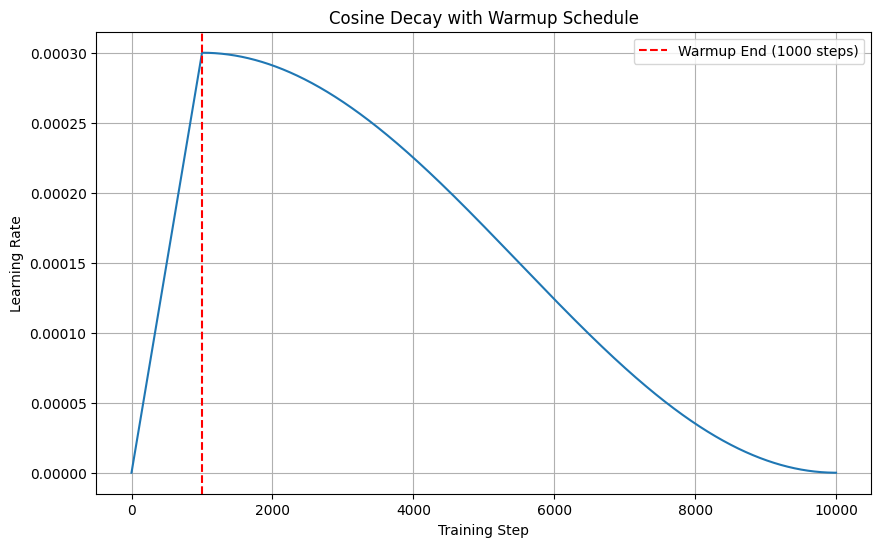

In [2]:
import torch
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

# --- Dummy Model and Optimizer ---
model = torch.nn.Linear(10, 2) # Example model
optimizer = optim.AdamW(model.parameters(), lr=1e-9, weight_decay=0.01) # Start with a dummy LR, scheduler will overwrite

# --- Schedule Parameters ---
peak_lr = 3e-4
total_steps = 10000
warmup_steps = 1000  # 10% of total steps
min_lr = 0 # Could also be peak_lr * 0.1

# --- Function to get LR at a given step ---
def get_cosine_warmup_lr(current_step, warmup_steps, total_steps, peak_lr, min_lr):
    if current_step < warmup_steps:
        # Linear warmup
        return peak_lr * float(current_step) / float(max(1, warmup_steps))
    elif current_step >= total_steps:
         # Reached the end
        return min_lr
    else:
        # Cosine decay phase
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        # Ensure decay starts from peak_lr and ends at min_lr
        decayed_lr = min_lr + (peak_lr - min_lr) * cosine_decay
        return decayed_lr

# --- Simulate Training Loop and Track LR ---
lrs = []
for step in range(total_steps):
    # Calculate LR for the current step
    current_lr = get_cosine_warmup_lr(step, warmup_steps, total_steps, peak_lr, min_lr)
    lrs.append(current_lr)

    # Set the LR in the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr

    # --- Your usual training steps ---
    # loss = model(...)
    # loss.backward()
    # optimizer.step()
    # optimizer.zero_grad()
    # ---------------------------------

    if step % 1000 == 0:
        print(f"Step: {step}, LR: {current_lr:.2e}")

print(f"Final LR reached: {lrs[-1]:.2e}")

# --- Plotting the LR Schedule ---
plt.figure(figsize=(10, 6))
plt.plot(range(total_steps), lrs)
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Cosine Decay with Warmup Schedule")
plt.axvline(warmup_steps, color='red', linestyle='--', label=f'Warmup End ({warmup_steps} steps)')
plt.legend()
plt.grid(True)
plt.show()

Here is an example of a nested loop in Python to print every combination of numbers between 0-9, excluding any combination that contains the number 5 or repeating digits:

```python
for i in range(10):  # First digit
    for j in range(10):  # Second digit
        for k in range(10):  # Third digit
            # Checking for the conditions
            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:
                print(i, j, k)
```

This code will generate and print every combination of three digits between 0-9 that do not contain the number 5 and do not have any repeating digits.

In [3]:
for i in range(10):  # First digit
    for j in range(10):  # Second digit
        for k in range(10):  # Third digit
            # Checking for the conditions
            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:
                print(i, j, k)

0 1 2
0 1 3
0 1 4
0 1 6
0 1 7
0 1 8
0 1 9
0 2 1
0 2 3
0 2 4
0 2 6
0 2 7
0 2 8
0 2 9
0 3 1
0 3 2
0 3 4
0 3 6
0 3 7
0 3 8
0 3 9
0 4 1
0 4 2
0 4 3
0 4 6
0 4 7
0 4 8
0 4 9
0 6 1
0 6 2
0 6 3
0 6 4
0 6 7
0 6 8
0 6 9
0 7 1
0 7 2
0 7 3
0 7 4
0 7 6
0 7 8
0 7 9
0 8 1
0 8 2
0 8 3
0 8 4
0 8 6
0 8 7
0 8 9
0 9 1
0 9 2
0 9 3
0 9 4
0 9 6
0 9 7
0 9 8
1 0 2
1 0 3
1 0 4
1 0 6
1 0 7
1 0 8
1 0 9
1 2 0
1 2 3
1 2 4
1 2 6
1 2 7
1 2 8
1 2 9
1 3 0
1 3 2
1 3 4
1 3 6
1 3 7
1 3 8
1 3 9
1 4 0
1 4 2
1 4 3
1 4 6
1 4 7
1 4 8
1 4 9
1 6 0
1 6 2
1 6 3
1 6 4
1 6 7
1 6 8
1 6 9
1 7 0
1 7 2
1 7 3
1 7 4
1 7 6
1 7 8
1 7 9
1 8 0
1 8 2
1 8 3
1 8 4
1 8 6
1 8 7
1 8 9
1 9 0
1 9 2
1 9 3
1 9 4
1 9 6
1 9 7
1 9 8
2 0 1
2 0 3
2 0 4
2 0 6
2 0 7
2 0 8
2 0 9
2 1 0
2 1 3
2 1 4
2 1 6
2 1 7
2 1 8
2 1 9
2 3 0
2 3 1
2 3 4
2 3 6
2 3 7
2 3 8
2 3 9
2 4 0
2 4 1
2 4 3
2 4 6
2 4 7
2 4 8
2 4 9
2 6 0
2 6 1
2 6 3
2 6 4
2 6 7
2 6 8
2 6 9
2 7 0
2 7 1
2 7 3
2 7 4
2 7 6
2 7 8
2 7 9
2 8 0
2 8 1
2 8 3
2 8 4
2 8 6
2 8 7
2 8 9
2 9 0
2 9 1
2 9 3
2 9 4
2 9 6
2 9 

In [8]:
def count_distinct_states(matrix):
    count = 0
    states = set()
    for row in matrix:
        for col in row:
            state = ''.join(col)
            if state not in states:
                count += 1
            states.add(state)
    return count

matrix = [['A', 'B', 'C'],
          ['A', 'B', 'D'],
          ['A', 'B', 'C']]
print(count_distinct_states(matrix))
# Output: 4

4


In [1]:
for i in range(10):  # First digit
    for j in range(10):  # Second digit
        for k in range(10):  # Third digit
            # Checking for the conditions
            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:
                print(i, j, k)

0 1 2
0 1 3
0 1 4
0 1 6
0 1 7
0 1 8
0 1 9
0 2 1
0 2 3
0 2 4
0 2 6
0 2 7
0 2 8
0 2 9
0 3 1
0 3 2
0 3 4
0 3 6
0 3 7
0 3 8
0 3 9
0 4 1
0 4 2
0 4 3
0 4 6
0 4 7
0 4 8
0 4 9
0 6 1
0 6 2
0 6 3
0 6 4
0 6 7
0 6 8
0 6 9
0 7 1
0 7 2
0 7 3
0 7 4
0 7 6
0 7 8
0 7 9
0 8 1
0 8 2
0 8 3
0 8 4
0 8 6
0 8 7
0 8 9
0 9 1
0 9 2
0 9 3
0 9 4
0 9 6
0 9 7
0 9 8
1 0 2
1 0 3
1 0 4
1 0 6
1 0 7
1 0 8
1 0 9
1 2 0
1 2 3
1 2 4
1 2 6
1 2 7
1 2 8
1 2 9
1 3 0
1 3 2
1 3 4
1 3 6
1 3 7
1 3 8
1 3 9
1 4 0
1 4 2
1 4 3
1 4 6
1 4 7
1 4 8
1 4 9
1 6 0
1 6 2
1 6 3
1 6 4
1 6 7
1 6 8
1 6 9
1 7 0
1 7 2
1 7 3
1 7 4
1 7 6
1 7 8
1 7 9
1 8 0
1 8 2
1 8 3
1 8 4
1 8 6
1 8 7
1 8 9
1 9 0
1 9 2
1 9 3
1 9 4
1 9 6
1 9 7
1 9 8
2 0 1
2 0 3
2 0 4
2 0 6
2 0 7
2 0 8
2 0 9
2 1 0
2 1 3
2 1 4
2 1 6
2 1 7
2 1 8
2 1 9
2 3 0
2 3 1
2 3 4
2 3 6
2 3 7
2 3 8
2 3 9
2 4 0
2 4 1
2 4 3
2 4 6
2 4 7
2 4 8
2 4 9
2 6 0
2 6 1
2 6 3
2 6 4
2 6 7
2 6 8
2 6 9
2 7 0
2 7 1
2 7 3
2 7 4
2 7 6
2 7 8
2 7 9
2 8 0
2 8 1
2 8 3
2 8 4
2 8 6
2 8 7
2 8 9
2 9 0
2 9 1
2 9 3
2 9 4
2 9 6
2 9 

In [2]:
def count_distinct_states(matrix):
    count = 0
    states = set()
    for row in matrix:
        for col in row:
            state = ''.join(col)
            if state not in states:
                count += 1
            states.add(state)
    return count

matrix = [['A', 'B', 'C'],
          ['A', 'B', 'D'],
          ['A', 'B', 'C']]
print(count_distinct_states(matrix))
# Output: 4

4
